### Setup

In [1]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import style
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format
style.use("ggplot")

/usr/local/lib64/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Load Dataset and Rndomization

In [2]:
california_housing_dataframe = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", sep=",")
california_housing_dataframe = california_housing_dataframe.reindex(np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207300.9
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,115983.8
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,14999.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119400.0
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180400.0
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265000.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500001.0


### Preprocess Data

In [3]:
def preprocess_features(california_housing_dataframe):
    selected_features = california_housing_dataframe[
        ["latitude",
         "longitude",
         "housing_median_age",
         "total_rooms",
         "total_bedrooms",
         "population",
         "households",
         "median_income"]
    ]
    preprocessed_features = selected_features.copy()
    preprocessed_features["rooms_per_person"] = (california_housing_dataframe["total_rooms"]/
                                                 california_housing_dataframe["population"])
    return preprocessed_features

def preprocess_targets(california_housing_dataframe):
    output_targets = pd.DataFrame()
    output_targets["median_house_value"] = (california_housing_dataframe["median_house_value"] / 1000.0)
    return output_targets

### Training set and Validation set

In [4]:
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

print("Training Examples Summary:")
display.display(training_examples.describe())
print("Validation Examples Summary:")
display.display(validation_examples.describe())

print("Training targets Summary:")
display.display(training_targets.describe())
print("Validation targets Summary:")
display.display(validation_targets.describe())

Training Examples Summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.6,2651.2,539.5,1432.4,501.3,3.9,2.0
std,2.1,2.0,12.6,2200.9,424.2,1154.1,387.2,1.9,1.1
min,32.5,-124.3,2.0,2.0,2.0,6.0,2.0,0.5,0.0
25%,33.9,-121.8,18.0,1461.0,295.0,785.8,280.0,2.6,1.5
50%,34.3,-118.5,29.0,2125.0,431.0,1161.0,406.0,3.6,1.9
75%,37.7,-118.0,37.0,3152.2,646.0,1722.0,604.0,4.8,2.3
max,42.0,-114.5,52.0,37937.0,5471.0,35682.0,5189.0,15.0,52.0


Validation Examples Summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.5,28.6,2625.7,539.1,1422.8,501.1,3.9,2.0
std,2.1,2.0,12.4,2129.0,414.9,1132.7,378.0,1.9,1.3
min,32.5,-124.3,1.0,8.0,1.0,3.0,1.0,0.5,0.1
25%,33.9,-121.8,18.0,1465.0,299.0,799.8,284.0,2.6,1.5
50%,34.2,-118.5,29.0,2135.0,440.0,1183.5,418.0,3.5,1.9
75%,37.7,-118.0,37.0,3150.0,659.0,1719.0,608.0,4.7,2.3
max,41.8,-114.3,52.0,32627.0,6445.0,28566.0,6082.0,15.0,55.2


Training targets Summary:


,median_house_value
count,12000.0
mean,207.3
std,116.2
min,15.0
25%,119.4
50%,180.2
75%,265.1
max,500.0


Validation targets Summary:


,median_house_value
count,5000.0
mean,207.3
std,115.5
min,17.5
25%,119.6
50%,180.4
75%,264.7
max,500.0


### Develop a Good Feature set

#### Correlation Matrix

In [5]:
correlation_dataframe = training_examples.copy()
correlation_dataframe["target"] = training_targets["median_house_value"]

correlation_dataframe.corr()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person,target
latitude,1.0,-0.9,-0.0,-0.0,-0.1,-0.1,-0.1,-0.1,0.2,-0.1
longitude,-0.9,1.0,-0.1,0.0,0.1,0.1,0.1,-0.0,-0.1,-0.0
housing_median_age,-0.0,-0.1,1.0,-0.4,-0.3,-0.3,-0.3,-0.1,-0.1,0.1
total_rooms,-0.0,0.0,-0.4,1.0,0.9,0.9,0.9,0.2,0.1,0.1
total_bedrooms,-0.1,0.1,-0.3,0.9,1.0,0.9,1.0,-0.0,0.0,0.0
population,-0.1,0.1,-0.3,0.9,0.9,1.0,0.9,0.0,-0.1,-0.0
households,-0.1,0.1,-0.3,0.9,1.0,0.9,1.0,0.0,-0.0,0.1
median_income,-0.1,-0.0,-0.1,0.2,-0.0,0.0,0.0,1.0,0.2,0.7
rooms_per_person,0.2,-0.1,-0.1,0.1,0.0,-0.1,-0.0,0.2,1.0,0.2
target,-0.1,-0.0,0.1,0.1,0.0,-0.0,0.1,0.7,0.2,1.0


### Construct Feature Columns

In [6]:
def construct_feature_columns(input_features):
    return set([tf.feature_column.numeric_column(my_features) for my_features in input_features])

### Input Function

In [7]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    features = {key: np.array(value) for key, value in dict(features).items()}
    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    if shuffle:
        ds = ds.shuffle(buffer_size=10000)
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

### Train Model

In [8]:
def train_model(learning_rate,
                steps,
                batch_size,
                training_examples,
                training_targets,
                validation_examples,
                validation_targets):
    periods = 10
    steps_per_period = steps / periods
    
    # Create linear_regressor and configure it
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(
        feature_columns = construct_feature_columns(training_examples),
        optimizer = my_optimizer
    )
    
    # Compute input_functions
    training_input_fn = lambda: my_input_fn(training_examples,
                                            training_targets["median_house_value"],
                                            batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(training_examples,
                                                    training_targets["median_house_value"],
                                                    shuffle=False,
                                                    num_epochs=1)
    predict_validation_input_fn = lambda: my_input_fn(validation_examples,
                                                      validation_targets["median_house_value"],
                                                      shuffle=False,
                                                      num_epochs=1)
    
    # Train the model in loop
    print("Training the model...")
    print("  RMSE (on training data):")
    training_rmse = []
    validation_rmse = []
    for period in range(0, periods):
        linear_regressor.train(
            input_fn = training_input_fn,
            steps = steps_per_period
        )
        
        # Predictions of training and validation
        training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
        training_predictions = np.array([item['predictions'][0] for item in training_predictions])
        validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
        validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
        
        # Compute trainig and validation root_mean_squared_error
        training_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(training_predictions,
                                                                                training_targets))
        validation_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(validation_predictions,
                                                                                  validation_targets))
        print("    Period %02d : %0.2f\t%0.2f" % (period+1,
                                                  training_root_mean_squared_error,
                                                  validation_root_mean_squared_error))
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
    print("Model training finished.")
    
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training", color="magenta")
    plt.plot(validation_rmse, label="validation", color="g")
    plt.legend()
    return linear_regressor

### Minimal Features

Training the model...
  RMSE (on training data):
    Period 01 : 165.71	165.38
    Period 02 : 123.49	122.98
    Period 03 : 122.51	122.02
    Period 04 : 116.96	116.40
    Period 05 : 115.90	115.33
    Period 06 : 115.37	114.78
    Period 07 : 114.84	114.30
    Period 08 : 114.62	114.06
    Period 09 : 114.38	113.92
    Period 10 : 113.52	113.01
Model training finished.


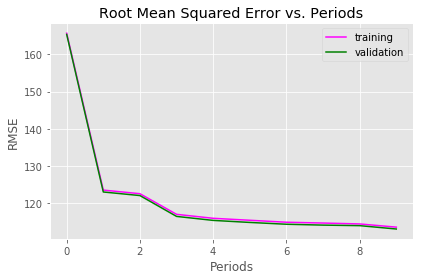

In [9]:
minimal_features = ["median_income", "latitude"]

assert minimal_features, "You must select atleast one feature!"

minimal_training_examples = training_examples[minimal_features]
minimal_validation_examples = validation_examples[minimal_features]

_ = train_model(
    learning_rate = 0.01,
    steps = 500,
    batch_size = 5,
    training_examples = minimal_training_examples,
    training_targets = training_targets,
    validation_examples = minimal_validation_examples,
    validation_targets = validation_targets
)

### Make better use of Latitude

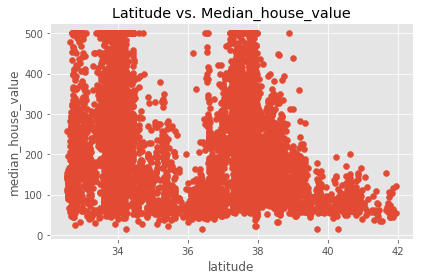

In [10]:
# Plotting latitude vs. median_house_value shows that there is no linear relationship. But two hills.
plt.ylabel("median_house_value")
plt.xlabel("latitude")
plt.title("Latitude vs. Median_house_value")
plt.tight_layout()
plt.scatter(training_examples["latitude"], training_targets["median_house_value"])
plt.show()